# Problem 2

In [18]:
from __future__ import print_function
import time
import numpy as np

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [20]:
import torchvision
import torchvision.transforms

In [21]:
import matplotlib.pyplot as plt

In [22]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

In [56]:
len(mnist_test)

10000

In [24]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

In [25]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=1),
            nn.Dropout(p=0.8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(256, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())


In [30]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [60]:
clf = Classifier()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.Adam(clf.parameters(), lr=5e-4)
scheduler_ = torch.optim.lr_scheduler.MultiStepLR(optimizer, [6,8], gamma=0.8)
criterion = nn.CrossEntropyLoss()
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

Epoch 0 Train Acc: 49.857 % Test Acc : 90.340 %
--------------------------------------------------------------
Epoch 1 Train Acc: 86.753 % Test Acc : 95.180 %
--------------------------------------------------------------
Epoch 2 Train Acc: 91.237 % Test Acc : 97.170 %
--------------------------------------------------------------
Epoch 3 Train Acc: 92.723 % Test Acc : 97.530 %
--------------------------------------------------------------
Epoch 4 Train Acc: 93.693 % Test Acc : 98.210 %
--------------------------------------------------------------
Epoch 5 Train Acc: 94.345 % Test Acc : 98.410 %
--------------------------------------------------------------
Epoch 6 Train Acc: 94.752 % Test Acc : 98.440 %
--------------------------------------------------------------
Epoch 7 Train Acc: 94.993 % Test Acc : 98.500 %
--------------------------------------------------------------
Epoch 8 Train Acc: 95.393 % Test Acc : 98.290 %
--------------------------------------------------------------
E

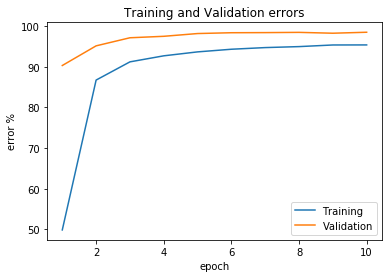

In [61]:
dict_err = {}
dict_err["tr"] = []
dict_err["val"] = []

for epoch in range(10):
    tr_losses = []
    tr_total = 0
    tr_correct = 0
    # Train
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        # scheduler_.step()
        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        tr_losses.append(loss.data.item())
        _, predicted = torch.max(nn.Softmax(outputs).data, 1)
        tr_total += targets.size(0)
        tr_correct += predicted.eq(targets.data).cpu().sum()
        tr_err = 100.*np.float32(tr_correct)/np.float32(tr_total)
        
#         if batch_idx%50==0:
#             print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    dict_err["tr"].append(tr_err)
    
    # Evaluate
    clf.eval()
    va_total = 0
    va_correct = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        _, predicted = torch.max(nn.Softmax(outputs).data, 1)
        va_total += targets.size(0)
        va_correct += predicted.eq(targets.data).cpu().sum()
        va_err = 100.*np.float32(va_correct)/np.float32(va_total)
    
    dict_err["val"].append(va_err)

    
    print('Epoch %d Train Acc: %.3f %% Test Acc : %.3f %%' % (epoch, tr_err, va_err))
    print('--------------------------------------------------------------')
    clf.train()

x = np.arange(1,len(dict_err["tr"])+1,1)
fig = plt.figure(1)
plt.title("Training and Validation errors")
plt.plot(x, dict_err["tr"], label="Training")
plt.plot(x, dict_err["val"], label="Validation")
plt.xlabel("epoch")
plt.ylabel("error %")
plt.legend()